In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

zip_train_path = '/content/drive/MyDrive/dataset/train.zip'
zip_val_path   = '/content/drive/MyDrive/dataset/val.zip'

base_dir  = '/content/temp_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')

def extract_zip(zip_path, dest_path):
    if not os.path.exists(dest_path):
        print(f"Membuat folder {dest_path}")
        os.makedirs(dest_path, exist_ok=True)

        print(f"Mengekstrak {zip_path} ke {dest_path}")
        !unzip -q "$zip_path" -d "$dest_path"
        print(f"Selesai mengekstrak ke {dest_path}")
    else:
        print(f"Folder {dest_path} sudah ada. Melewati ekstraksi.")

if os.path.exists(zip_train_path):
    extract_zip(zip_train_path, train_dir)
else:
    print(f"PERINGATAN: File {zip_train_path} tidak ditemukan di Drive!")

if os.path.exists(zip_val_path):
    extract_zip(zip_val_path, val_dir)
else:
    print(f"PERINGATAN: File {zip_val_path} tidak ditemukan di Drive!")

DATA_DIR = base_dir
TRAIN_DIR = train_dir
VAL_DIR = val_dir

print("\n--- Pengecekan Struktur Folder ---")
if os.path.exists(TRAIN_DIR):
    print(f"Isi {TRAIN_DIR}: {os.listdir(TRAIN_DIR)}")

    subfolders = os.listdir(TRAIN_DIR)
    if len(subfolders) > 0:
        first_sub = os.path.join(TRAIN_DIR, subfolders[0])
        if os.path.isdir(first_sub):
             print(f"Contoh isi dalam '{subfolders[0]}': {os.listdir(first_sub)[:5]}")

if os.path.exists(VAL_DIR):
    print(f"Isi {VAL_DIR}: {os.listdir(VAL_DIR)}")

In [ ]:
import os
import shutil

def remove_macos_artifacts(path):
    print(f"Membersihkan artefak MacOS di: {path}")
    count_files = 0
    count_folders = 0

    for root, dirs, files in os.walk(path):
        if '__MACOSX' in dirs:
            rm_path = os.path.join(root, '__MACOSX')
            try:
                shutil.rmtree(rm_path)
                count_folders += 1
            except Exception as e:
                print(f"Gagal hapus {rm_path}: {e}")
            dirs.remove('__MACOSX')

        for file in files:
            if file.startswith('._'):
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    count_files += 1
                except Exception as e:
                    print(f"Gagal hapus {file_path}: {e}")

    print(f"Selesai! Dihapus: {count_folders} folder __MACOSX dan {count_files} file metadata.")

remove_macos_artifacts(DATA_DIR)

In [ ]:
import os
from PIL import Image

def validate_and_clean_images(root_dir):
    print(f"Memulai pengecekan integritas gambar di: {root_dir}")
    print("Proses ini mungkin memakan waktu 1-2 menit...")

    bad_files = 0
    checked_files = 0

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                checked_files += 1

                try:
                    with Image.open(file_path) as img:
                        img.verify()
                except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                    print(f"File rusak ditemukan: {file_path}")
                    try:
                        os.remove(file_path)
                        print(f"Berhasil dihapus")
                        bad_files += 1
                    except Exception as del_err:
                        print(f"Gagal menghapus: {del_err}")

    print("-" * 30)
    print(f"Total diperiksa: {checked_files}")
    print(f"Total file rusak dihapus: {bad_files}")

validate_and_clean_images(DATA_DIR)

In [ ]:
class FFTTransform:
    def __call__(self, img):

        img_gray = img.convert('L')
        img_array = np.array(img_gray)

        f = np.fft.fft2(img_array)
        fshift = np.fft.fftshift(f)

        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-8)

        magnitude_spectrum = np.nan_to_num(magnitude_spectrum)
        ms_min = np.min(magnitude_spectrum)
        ms_max = np.max(magnitude_spectrum)

        if ms_max - ms_min > 0:
            img_fft = 255 * (magnitude_spectrum - ms_min) / (ms_max - ms_min)
        else:
            img_fft = np.zeros_like(magnitude_spectrum)

        img_fft = img_fft.astype(np.uint8)

        return Image.fromarray(img_fft).convert("RGB")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        FFTTransform(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        FFTTransform(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(TRAIN_DIR, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(VAL_DIR, 'val'), data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
}

class_names = image_datasets['train'].classes
print(f"URUTAN KELAS: {class_names}")
for i, class_name in enumerate(class_names):
    print(f"Index {i} = {class_name}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_corrects += torch.sum(preds == labels.data)

            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model_efficientnet_fft.pth')
                print("Model saved!")

train_model(model, num_epochs=30)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

model_eval = models.efficientnet_b0(weights=None)
num_ftrs = model_eval.classifier[1].in_features
model_eval.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 2)
)

checkpoint_path = 'best_model_efficientnet_fft.pth'

if os.path.exists(checkpoint_path):
    print(f"Memuat model terbaik dari: {checkpoint_path}")
    model_eval.load_state_dict(torch.load(checkpoint_path, map_location=device))
else:
    print("File best model tidak ditemukan")
    model_eval = model

model_eval = model_eval.to(device)
model_eval.eval()
print("Model siap dievaluasi")

Sedang memproses data validasi...


100%|██████████| 38/38 [00:13<00:00,  2.86it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

          ai       0.99      0.98      0.99       600
        real       0.98      0.99      0.99       600

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



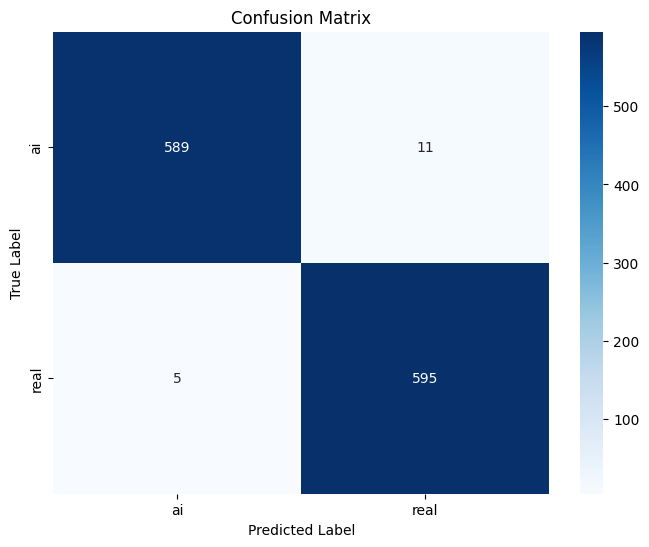


Akurasi Akhir pada Data Validasi: 98.67%


In [19]:
def evaluate_performance(model, dataloader):
    y_true = []
    y_pred = []

    print("Sedang memproses data validasi...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.cpu().numpy()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()

            y_true.extend(labels)
            y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_performance(model_eval, dataloaders['val'])

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

acc = accuracy_score(y_true, y_pred)
print(f"\nAkurasi Akhir pada Data Validasi: {acc*100:.2f}%")